In [1]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

from random import randint

In [2]:
protoFile = "pose/coco/pose_deploy_linevec.prototxt"
weightsFile = "pose/coco/pose_iter_440000.caffemodel"
nPoints = 18
# COCO Output Format
keypointsMapping = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho', 
                    'L-Elb', 'L-Wr', 'R-Hip', 'R-Knee', 'R-Ank', 'L-Hip', 
                    'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 'R-Ear', 'L-Ear']

POSE_PAIRS = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],
              [1,8], [8,9], [9,10], [1,11], [11,12], [12,13],
              [1,0], [0,14], [14,16], [0,15], [15,17],
              [2,17], [5,16] ]

# index of pafs correspoding to the POSE_PAIRS
# e.g for POSE_PAIR(1,2), the PAFs are located at indices (31,32) of output, Similarly, (1,5) -> (39,40) and so on.
mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44], 
          [19,20], [21,22], [23,24], [25,26], [27,28], [29,30], 
          [47,48], [49,50], [53,54], [51,52], [55,56], 
          [37,38], [45,46]]

colors = [ [0,100,255], [0,100,255], [0,255,255], [0,100,255], [0,255,255], [0,100,255],
         [0,255,0], [255,200,100], [255,0,255], [0,255,0], [255,200,100], [255,0,255],
         [0,0,255], [255,0,0], [200,200,0], [255,0,0], [200,200,0], [0,0,0]]


In [3]:
# Find the Keypoints using Non Maximum Suppression on the Confidence Map
def getKeypoints(probMap, threshold=0.1):
    
    mapSmooth = cv2.GaussianBlur(probMap,(3,3),0,0)
    print("mapSmooth shot")
    plt.imshow(mapSmooth)
    plt.show()

    mapMask = np.uint8(mapSmooth>threshold)
    print("mapMask shot")
    plt.imshow(mapMask)
    plt.show()
    keypoints = []
    
    #find the blobs
    contours, _ = cv2.findContours(mapMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    #for each blob find the maxima
    for cnt in contours:
        blobMask = np.zeros(mapMask.shape)
        blobMask = cv2.fillConvexPoly(blobMask, cnt, 1)
        maskedProbMap = mapSmooth * blobMask
        _, maxVal, _, maxLoc = cv2.minMaxLoc(maskedProbMap)
        keypoints.append(maxLoc + (probMap[maxLoc[1], maxLoc[0]],))

    return keypoints


## Use the following equation for finding valid joint-pairs

![](./pose-estimation-paf-equation.png)

In the above equation:

L is the PAF;

d is the vector joining two joints;

p is the interpolated point between two joints;

It is implemented using the dot product between the PAF and the vector $d_{ij}$

In [4]:
# Find valid connections between the different joints of a all persons present
def getValidPairs(output):
    valid_pairs = []
    invalid_pairs = []
    n_interp_samples = 10
    paf_score_th = 0.1
    conf_th = 0.7
    # loop for every POSE_PAIR
    for k in range(len(mapIdx)):
        # A->B constitute a limb
        pafA = output[0, mapIdx[k][0], :, :]
        pafB = output[0, mapIdx[k][1], :, :]
        pafA = cv2.resize(pafA, (frameWidth, frameHeight))
        pafB = cv2.resize(pafB, (frameWidth, frameHeight))

        # Find the keypoints for the first and second limb
        candA = detected_keypoints[POSE_PAIRS[k][0]]
        candB = detected_keypoints[POSE_PAIRS[k][1]]
        nA = len(candA)
        nB = len(candB)

        # If keypoints for the joint-pair is detected
        # check every joint in candA with every joint in candB 
        # Calculate the distance vector between the two joints
        # Find the PAF values at a set of interpolated points between the joints
        # Use the above formula to compute a score to mark the connection valid
        
        if( nA != 0 and nB != 0):
            valid_pair = np.zeros((0,3))
            for i in range(nA):
                max_j=-1
                maxScore = -1
                found = 0
                for j in range(nB):
                    # Find d_ij
                    d_ij = np.subtract(candB[j][:2], candA[i][:2])
                    norm = np.linalg.norm(d_ij)
                    if norm:
                        d_ij = d_ij / norm
                    else:
                        continue
                    # Find p(u)
                    interp_coord = list(zip(np.linspace(candA[i][0], candB[j][0], num=n_interp_samples),
                                            np.linspace(candA[i][1], candB[j][1], num=n_interp_samples)))
                    # Find L(p(u))
                    paf_interp = []
                    for k in range(len(interp_coord)):
                        paf_interp.append([pafA[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))],
                                           pafB[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))] ]) 
                    # Find E
                    paf_scores = np.dot(paf_interp, d_ij)
                    avg_paf_score = sum(paf_scores)/len(paf_scores)
                    
                    # Check if the connection is valid
                    # If the fraction of interpolated vectors aligned with PAF is higher then threshold -> Valid Pair  
                    if ( len(np.where(paf_scores > paf_score_th)[0]) / n_interp_samples ) > conf_th :
                        if avg_paf_score > maxScore:
                            max_j = j
                            maxScore = avg_paf_score
                            found = 1
                # Append the connection to the list
                if found:            
                    valid_pair = np.append(valid_pair, [[candA[i][3], candB[max_j][3], maxScore]], axis=0)

            # Append the detected connections to the global list
            valid_pairs.append(valid_pair)
        else: # If no keypoints are detected
            print("No Connection : k = {}".format(k))
            invalid_pairs.append(k)
            valid_pairs.append([])
    print(valid_pairs)
    return valid_pairs, invalid_pairs


In [5]:
# This function creates a list of keypoints belonging to each person
# For each detected valid pair, it assigns the joint(s) to a person
# It finds the person and index at which the joint should be added. This can be done since we have an id for each joint
def getPersonwiseKeypoints(valid_pairs, invalid_pairs):
    # the last number in each row is the overall score 
    personwiseKeypoints = -1 * np.ones((0, 19))

    for k in range(len(mapIdx)):
        if k not in invalid_pairs:
            partAs = valid_pairs[k][:,0]
            partBs = valid_pairs[k][:,1]
            indexA, indexB = np.array(POSE_PAIRS[k])

            for i in range(len(valid_pairs[k])): 
                found = 0
                person_idx = -1
                for j in range(len(personwiseKeypoints)):
                    if personwiseKeypoints[j][indexA] == partAs[i]:
                        person_idx = j
                        found = 1
                        break

                if found:
                    personwiseKeypoints[person_idx][indexB] = partBs[i]
                    personwiseKeypoints[person_idx][-1] += keypoints_list[partBs[i].astype(int), 2] + valid_pairs[k][i][2]

                # if find no partA in the subset, create a new subset
                elif not found and k < 17:
                    row = -1 * np.ones(19)
                    row[indexA] = partAs[i]
                    row[indexB] = partBs[i]
                    # add the keypoint_scores for the two keypoints and the paf_score 
                    row[-1] = sum(keypoints_list[valid_pairs[k][i,:2].astype(int), 2]) + valid_pairs[k][i][2]
                    personwiseKeypoints = np.vstack([personwiseKeypoints, row])
    return personwiseKeypoints

In [38]:
image1 = cv2.imread("5.jpg")
frameWidth = image1.shape[1]
frameHeight = image1.shape[0]

#### Load the network and pass the image through the network

In [39]:
t = time.time()
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

# Fix the input Height and get the width according to the Aspect Ratio
inHeight = 368
inWidth = int((inHeight/frameHeight)*frameWidth)

inpBlob = cv2.dnn.blobFromImage(image1, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

net.setInput(inpBlob)
output = net.forward()
print("Time Taken = {}".format(time.time() - t))

Time Taken = 19.05085301399231


#### Slice a probability map ( for e.g Nose ) from the output for a specific keypoint and plot the heatmap ( after resizing ) on the image itself

(-0.5, 1279.5, 719.5, -0.5)

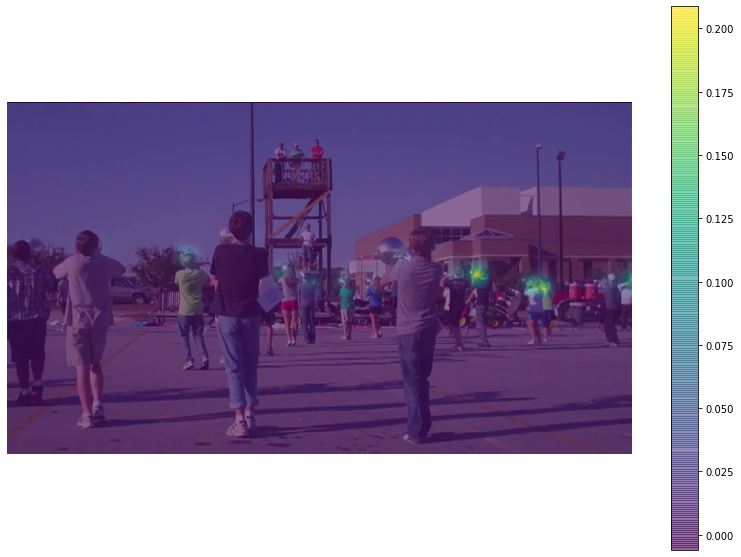

In [40]:
i = 0
probMap = output[0, i, :, :]
probMap = cv2.resize(probMap, (frameWidth, frameHeight))
plt.figure(figsize=[14,10])
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.imshow(probMap, alpha=0.6)
plt.colorbar()
plt.axis("off")

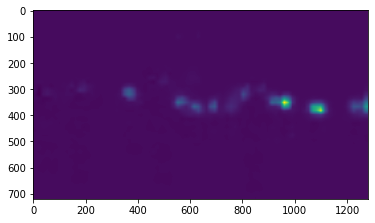

(720, 1280)
mapSmooth shot


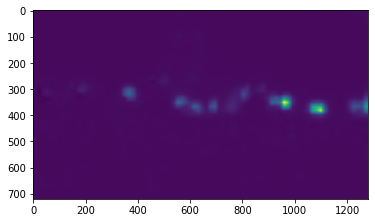

mapMask shot


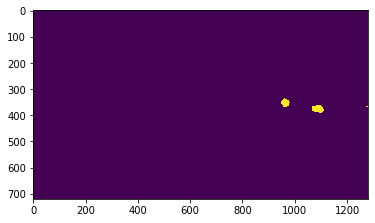

Keypoints - Nose : [(1273, 367, 0.106606245), (1100, 383, 0.19596067), (960, 352, 0.20869109)]


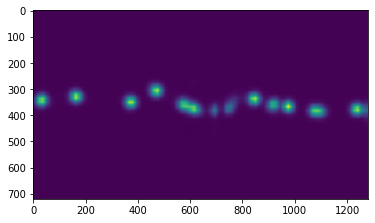

(720, 1280)
mapSmooth shot


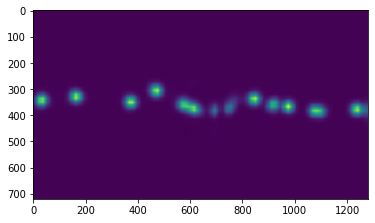

mapMask shot


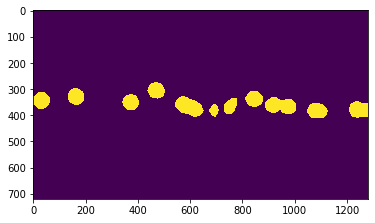

Keypoints - Neck : [(694, 383, 0.39149338), (1084, 383, 0.7661264), (1240, 382, 0.8121016), (756, 368, 0.34633213), (975, 367, 0.9408605), (615, 369, 0.73131293), (368, 352, 0.8177827), (38, 337, 0.75117207), (850, 336, 0.85000616), (164, 335, 0.8225433), (475, 305, 0.8539224)]


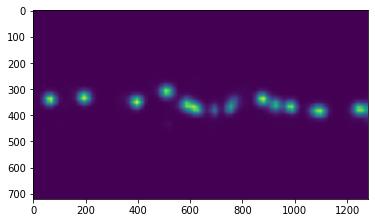

(720, 1280)
mapSmooth shot


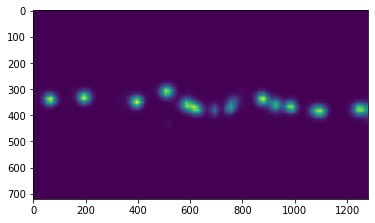

mapMask shot


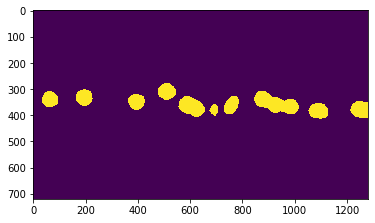

Keypoints - R-Sho : [(694, 383, 0.33276442), (1099, 383, 0.7790642), (1242, 382, 0.7058879), (756, 367, 0.52214843), (616, 368, 0.78668725), (397, 351, 0.87113965), (69, 336, 0.80637014), (881, 336, 0.8432033), (195, 336, 0.8513), (507, 305, 0.7654121)]


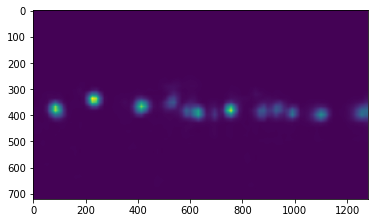

(720, 1280)
mapSmooth shot


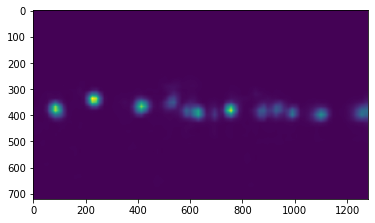

mapMask shot


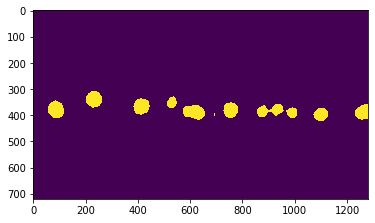

Keypoints - R-Elb : [(694, 398, 0.112047926), (1100, 399, 0.37086454), (991, 398, 0.2937241), (631, 384, 0.4257914), (1257, 398, 0.27491114), (929, 382, 0.20994708), (756, 383, 0.68472755), (86, 382, 0.6312988), (413, 367, 0.60455406), (537, 352, 0.20214243), (227, 337, 0.7459586)]


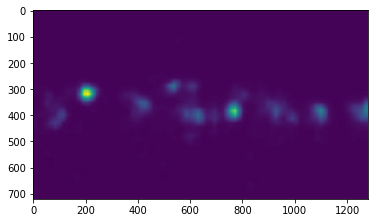

(720, 1280)
mapSmooth shot


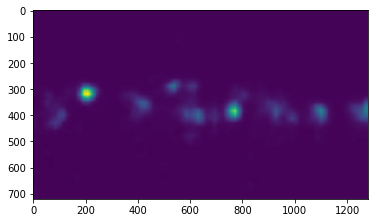

mapMask shot


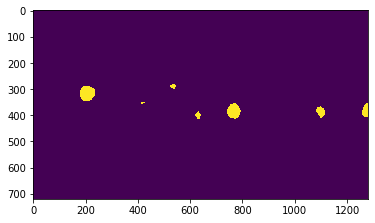

Keypoints - R-Wr : [(631, 399, 0.13156088), (1100, 383, 0.18077403), (1273, 382, 0.1574518), (772, 383, 0.3177042), (414, 352, 0.10682462), (209, 320, 0.3895109), (538, 289, 0.1472733)]


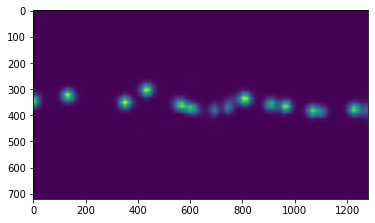

(720, 1280)
mapSmooth shot


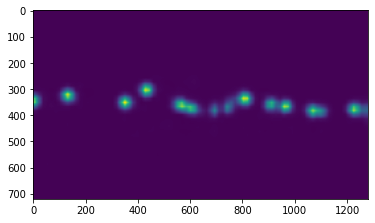

mapMask shot


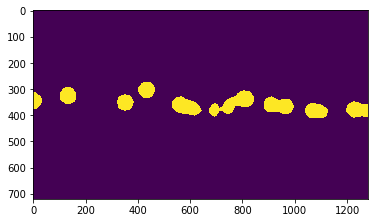

Keypoints - L-Sho : [(1069, 383, 0.7732414), (1225, 382, 0.7687575), (960, 367, 0.80281657), (569, 367, 0.7659692), (351, 352, 0.9323447), (0, 351, 0.6951635), (804, 336, 0.85987735), (132, 321, 0.8552609), (430, 305, 0.84954756)]


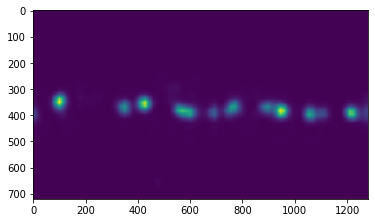

(720, 1280)
mapSmooth shot


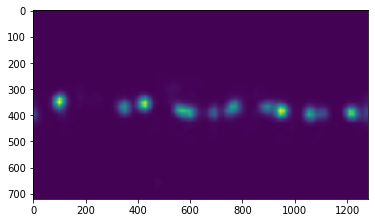

mapMask shot


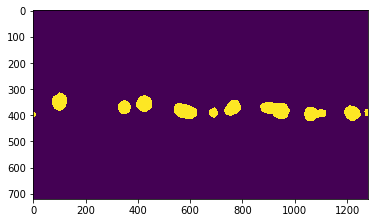

Keypoints - L-Elb : [(0, 398, 0.12316596), (1273, 384, 0.117734775), (694, 397, 0.18514927), (1054, 398, 0.39940625), (1210, 384, 0.47111526), (570, 383, 0.47059906), (945, 383, 0.6249432), (350, 368, 0.33331934), (758, 368, 0.3589495), (428, 352, 0.58141613), (101, 351, 0.6448642)]


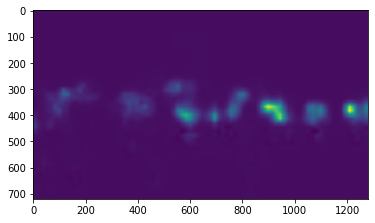

(720, 1280)
mapSmooth shot


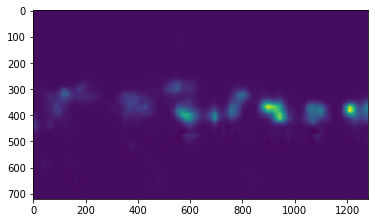

mapMask shot


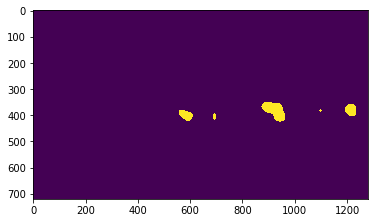

Keypoints - L-Wr : [(694, 400, 0.12857461), (585, 399, 0.17158517), (1100, 383, 0.11060384), (1210, 382, 0.26654646), (898, 368, 0.25555304)]


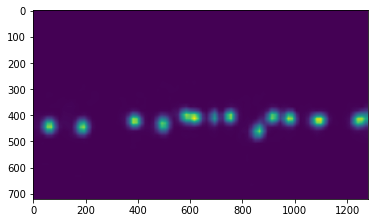

(720, 1280)
mapSmooth shot


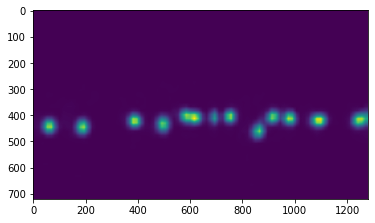

mapMask shot


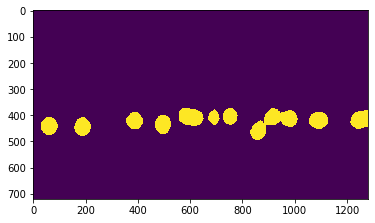

Keypoints - R-Hip : [(194, 445, 0.6791719), (68, 445, 0.6728894), (492, 430, 0.6133442), (1099, 415, 0.76360244), (383, 429, 0.67902124), (1255, 415, 0.70792466), (694, 414, 0.42867512), (976, 414, 0.7129321), (756, 400, 0.6651829), (616, 414, 0.8043263)]


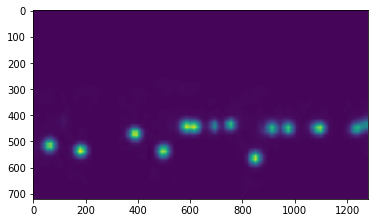

(720, 1280)
mapSmooth shot


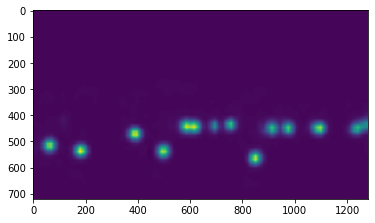

mapMask shot


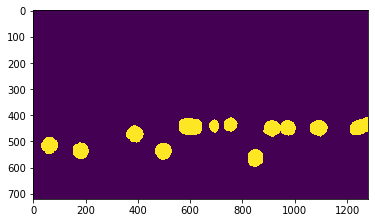

Keypoints - R-Knee : [(850, 570, 0.7677104), (492, 539, 0.7421303), (179, 539, 0.8633109), (69, 509, 0.6779789), (396, 476, 0.7631006), (1099, 446, 0.7311548), (975, 446, 0.64137137), (694, 445, 0.4218519), (1241, 446, 0.5557061), (616, 445, 0.8062006), (756, 431, 0.60205495)]


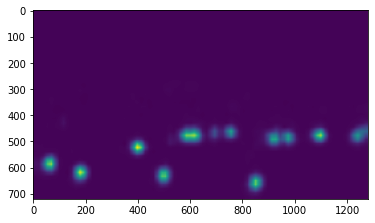

(720, 1280)
mapSmooth shot


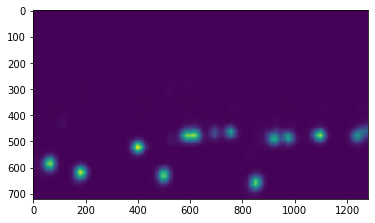

mapMask shot


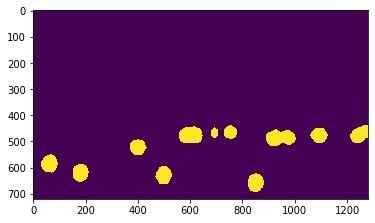

Keypoints - R-Ank : [(850, 663, 0.65024436), (505, 633, 0.6332219), (179, 618, 0.83804464), (69, 586, 0.72337484), (398, 524, 0.8740005), (927, 492, 0.5163043), (1099, 477, 0.7571676), (694, 462, 0.21318823), (615, 477, 0.75067663), (1240, 477, 0.4657813), (756, 462, 0.49309403)]


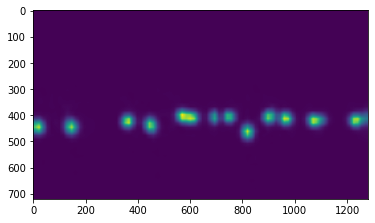

(720, 1280)
mapSmooth shot


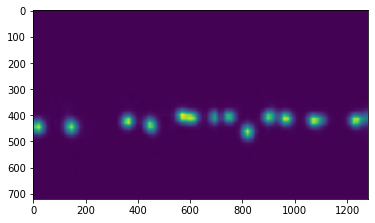

mapMask shot


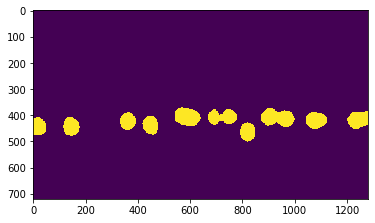

Keypoints - L-Hip : [(819, 462, 0.7217092), (22, 446, 0.72180545), (148, 446, 0.6862188), (445, 444, 0.6239756), (366, 429, 0.73383206), (1070, 416, 0.7092667), (1239, 415, 0.7006895), (742, 400, 0.50639266), (961, 414, 0.7388682), (570, 399, 0.7972479)]


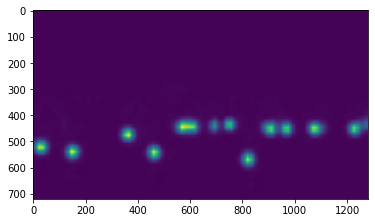

(720, 1280)
mapSmooth shot


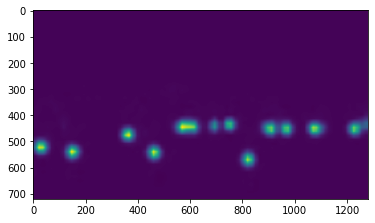

mapMask shot


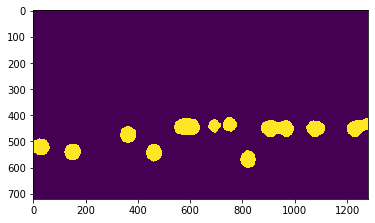

Keypoints - L-Knee : [(819, 571, 0.75171393), (460, 540, 0.8048524), (148, 540, 0.840327), (24, 524, 0.7877541), (366, 477, 0.8538743), (1070, 446, 0.72165805), (912, 447, 0.6477361), (694, 445, 0.43153176), (1225, 447, 0.66001946), (570, 445, 0.85490245), (756, 431, 0.5669969)]


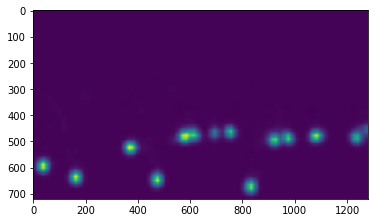

(720, 1280)
mapSmooth shot


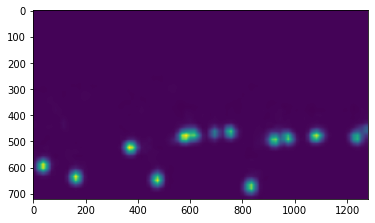

mapMask shot


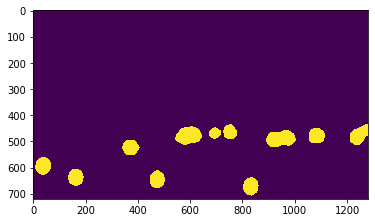

Keypoints - L-Ank : [(834, 666, 0.663441), (475, 649, 0.7881126), (163, 634, 0.8096758), (39, 588, 0.7864182), (367, 524, 0.8451587), (927, 493, 0.65154517), (1084, 477, 0.7695529), (694, 462, 0.33887798), (585, 477, 0.8398492), (1240, 491, 0.524176), (756, 462, 0.59156257)]


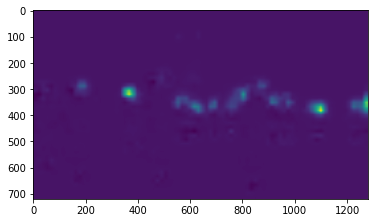

(720, 1280)
mapSmooth shot


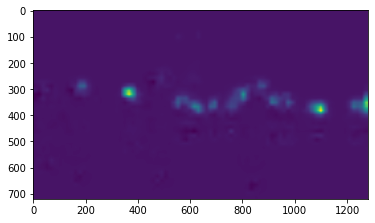

mapMask shot


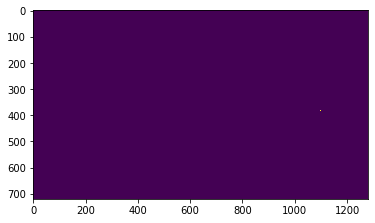

Keypoints - R-Eye : [(1100, 382, 0.10728593)]


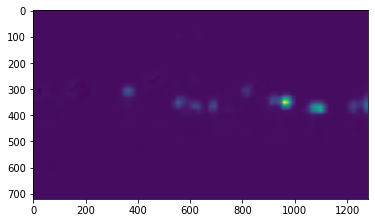

(720, 1280)
mapSmooth shot


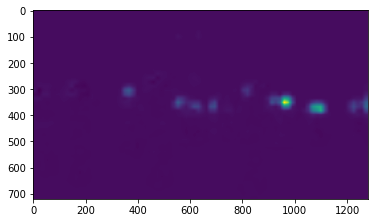

mapMask shot


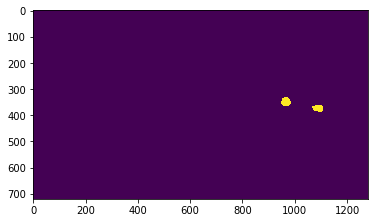

Keypoints - L-Eye : [(1099, 382, 0.14583425), (960, 352, 0.2418616)]


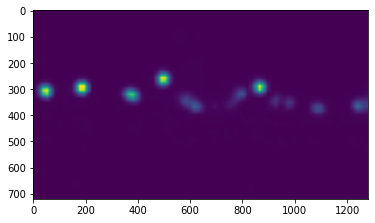

(720, 1280)
mapSmooth shot


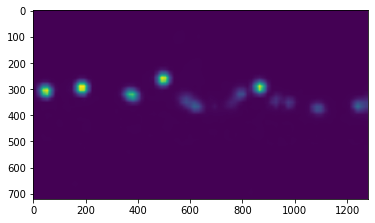

mapMask shot


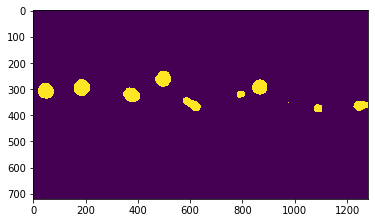

Keypoints - R-Ear : [(1085, 369, 0.15587851), (975, 352, 0.10970422), (1241, 367, 0.24357505), (617, 367, 0.2064472), (789, 320, 0.16482274), (381, 321, 0.49817672), (53, 305, 0.67304575), (180, 290, 0.6932966), (866, 290, 0.65555316), (492, 258, 0.670629)]


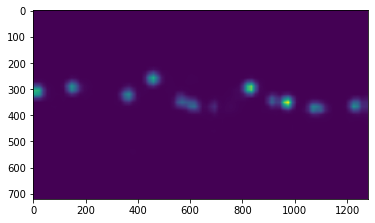

(720, 1280)
mapSmooth shot


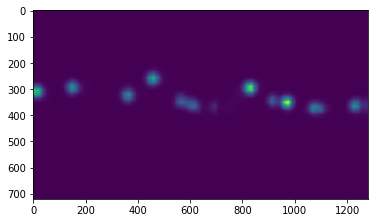

mapMask shot


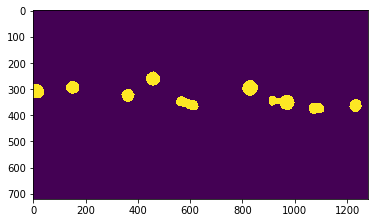

Keypoints - L-Ear : [(1070, 368, 0.3219013), (1225, 367, 0.3772964), (615, 367, 0.26100546), (975, 352, 0.753647), (366, 321, 0.3467044), (0, 306, 0.4944988), (148, 290, 0.3783248), (834, 290, 0.58643824), (460, 258, 0.45897207)]


In [41]:
detected_keypoints = []
keypoints_list = np.zeros((0,3))
keypoint_id = 0
threshold = 0.1

for part in range(nPoints):
    probMap = output[0,part,:,:]
    probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))
    plt.imshow(probMap)
    plt.show()
    print(probMap.shape)
#     plt.figure()
#     plt.imshow(255*np.uint8(probMap>threshold))
    keypoints = getKeypoints(probMap, threshold)
    print("Keypoints - {} : {}".format(keypointsMapping[part], keypoints))
    keypoints_with_id = []
    for i in range(len(keypoints)):
        keypoints_with_id.append(keypoints[i] + (keypoint_id,))
        keypoints_list = np.vstack([keypoints_list, keypoints[i]])
        keypoint_id += 1

    detected_keypoints.append(keypoints_with_id)


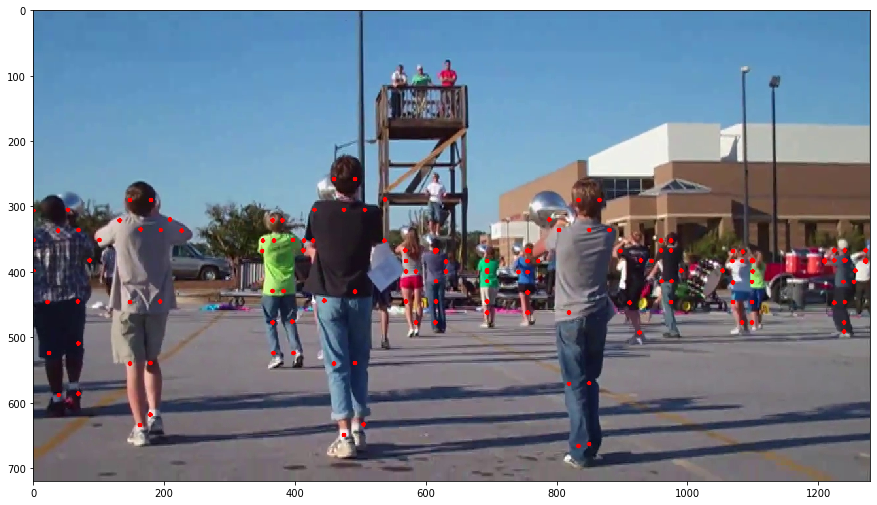

In [42]:
frameClone = image1.copy()
for i in range(nPoints):
    for j in range(len(detected_keypoints[i])):
        cv2.circle(frameClone, detected_keypoints[i][j][0:2], 3, [0,0,255], -1, cv2.LINE_AA)
plt.figure(figsize=[15,15])
plt.imshow(frameClone[:,:,[2,1,0]])

In [43]:
valid_pairs, invalid_pairs = getValidPairs(output)

[array([[ 4.        , 15.        ,  0.34445896],
       [ 5.        , 16.        ,  0.70762174],
       [ 8.        , 18.        ,  0.56565927],
       [ 9.        , 19.        ,  1.00107946],
       [10.        , 20.        ,  0.74917384],
       [11.        , 21.        ,  0.94778016],
       [12.        , 22.        ,  0.97832303],
       [13.        , 23.        ,  0.9560247 ]]), array([[ 4.        , 42.        ,  0.56903849],
       [ 5.        , 43.        ,  0.76472258],
       [ 7.        , 44.        ,  0.86199225],
       [ 8.        , 45.        ,  0.75822864],
       [ 9.        , 46.        ,  1.00681574],
       [10.        , 47.        ,  0.71381016],
       [11.        , 48.        ,  0.87288666],
       [12.        , 49.        ,  0.85797021],
       [13.        , 50.        ,  0.98029951]]), array([[14.        , 24.        ,  0.20239078],
       [15.        , 25.        ,  0.27130824],
       [17.        , 30.        ,  0.5195588 ],
       [18.        , 27.        ,  

In [44]:
personwiseKeypoints = getPersonwiseKeypoints(valid_pairs, invalid_pairs)

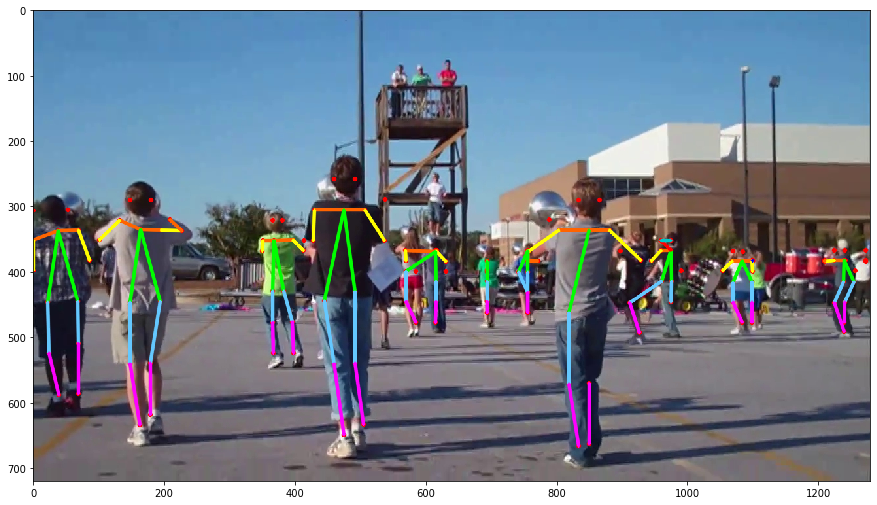

In [45]:
for i in range(17):
    for n in range(len(personwiseKeypoints)):
        index = personwiseKeypoints[n][np.array(POSE_PAIRS[i])]
        if -1 in index:
            continue
        B = np.int32(keypoints_list[index.astype(int), 0])
        A = np.int32(keypoints_list[index.astype(int), 1])
        cv2.line(frameClone, (B[0], A[0]), (B[1], A[1]), colors[i], 3, cv2.LINE_AA)
        
plt.figure(figsize=[15,15])
plt.imshow(frameClone[:,:,[2,1,0]])